In [1]:
import os
import random
import shutil
import pandas as pd
import pickle
import numpy as np
import seaborn as sns

from sklearn.datasets import load_files

# from keras.utils import to_categorical # Changed np_utils to to_categorical
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

import warnings
warnings.filterwarnings('ignore')

2025-09-24 16:14:16.216490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758730456.395747      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758730456.445609      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os, random, shutil

def prepare_data(base_input_path, base_output_path, train_ratio=0.7, val_ratio=0.15):
    labels = [d for d in os.listdir(base_input_path) if os.path.isdir(os.path.join(base_input_path, d))]
    for label in labels:
        input_folder = os.path.join(base_input_path, label)
        images = os.listdir(input_folder)
        random.shuffle(images)
        
        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        # Directories
        train_class_dir = os.path.join(base_output_path, 'training', label)
        val_class_dir = os.path.join(base_output_path, 'validation', label)
        test_class_dir = os.path.join(base_output_path, 'testing', label)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        # Copy images
        for i, img_name in enumerate(images):
            src_path = os.path.join(input_folder, img_name)
            if i < n_train:
                dest_path = os.path.join(train_class_dir, img_name)
            elif i < n_train + n_val:
                dest_path = os.path.join(val_class_dir, img_name)
            else:
                dest_path = os.path.join(test_class_dir, img_name)
            shutil.copy(src_path, dest_path)

# Example usage:
prepare_data(
    base_input_path="/kaggle/input/state-farm-distracted-driver-detection/imgs/train",
    base_output_path="/kaggle/working/master_data",
    train_ratio=0.7,
    val_ratio=0.15
)

In [3]:
train_dir = "/kaggle/working/master_data/training"
validation_dir = "/kaggle/working/master_data/validation"
test_dir = "/kaggle/working/master_data/testing"

train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize pixel values
    rotation_range=30,        # rotate images up to 30 degrees
    width_shift_range=0.2,    # horizontal shifts
    height_shift_range=0.2,   # vertical shifts
    shear_range=0.2,          # shearing transformations
    zoom_range=0.2,           # zoom in/out
    horizontal_flip=False,     # flip horizontally
    brightness_range=[0.7,1.3], # random brightness
    fill_mode='nearest'       # fill missing pixels after transformation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 15692 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.
Found 3374 images belonging to 10 classes.


In [15]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 10)


In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
# ======================
# Use inceptionv3 as base model
# ======================
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
predictions = layers.Dense(10, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 25,080,298 (95.67 MB)

 Trainable params: 3,277,514 (12.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
from tensorflow.keras import optimizers
# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["acc"]
)

In [19]:
train_samples=train_generator.samples
val_samples=val_generator.samples
test_samples=test_generator.samples
batch_size=16

In [20]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [21]:
history=model.fit(train_generator,
                  epochs=30,
                  steps_per_epoch = train_samples // batch_size,
                  validation_data=val_generator,
                  validation_steps=val_samples // batch_size
                 ,class_weight=class_weights)

Epoch 1/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 224s 214ms/step - acc: 0.2082 - loss: 2.2121 - val_acc: 0.3803 - val_loss: 1.7365
Epoch 2/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 199s 202ms/step - acc: 0.3821 - loss: 1.7209 - val_acc: 0.5006 - val_loss: 1.3716
Epoch 3/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 199s 203ms/step - acc: 0.4746 - loss: 1.4801 - val_acc: 0.6155 - val_loss: 1.1205
Epoch 4/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 199s 203ms/step - acc: 0.5195 - loss: 1.3358 - val_acc: 0.6486 - val_loss: 1.0132
Epoch 5/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 200s 204ms/step - acc: 0.5504 - loss: 1.2447 - val_acc: 0.6811 - val_loss: 0.9415
Epoch 6/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 202s 206ms/step - acc: 0.5859 - loss: 1.1728 - val_acc: 0.6974 - val_loss: 0.8936
Epoch 7/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 199s 203ms/step - acc: 0.5965 - loss: 1.1312 - val_acc: 0.6891 - val_loss: 0.8735
Epoch 8/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 199s 203ms/step - acc: 0.6070 - loss: 1.0953 - val_acc: 0.6769 - val_loss: 0.8941
Epoch 9/30
980/980 ━━━━━

In [22]:
# ======================
# 🔹 Save Weights
# ======================
model.save("/kaggle/working/driver_model_inceptionv3.h5")

In [23]:
results = model.evaluate(test_generator,steps=len(test_generator), verbose=1)

print("Test Accuracy:", results[1])
print("Test Loss:", results[0])

106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - acc: 0.7838 - loss: 0.6243
Test Accuracy: 0.8097214102745056
Test Loss: 0.5588598251342773


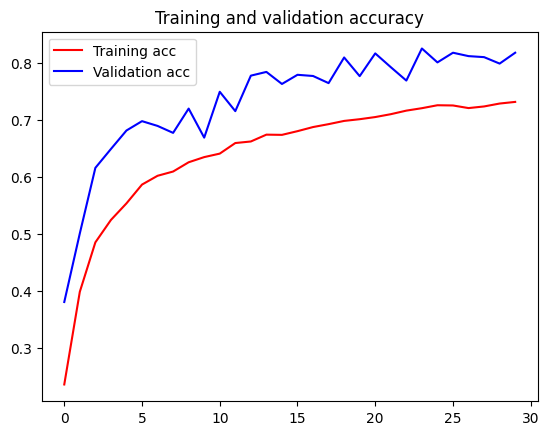

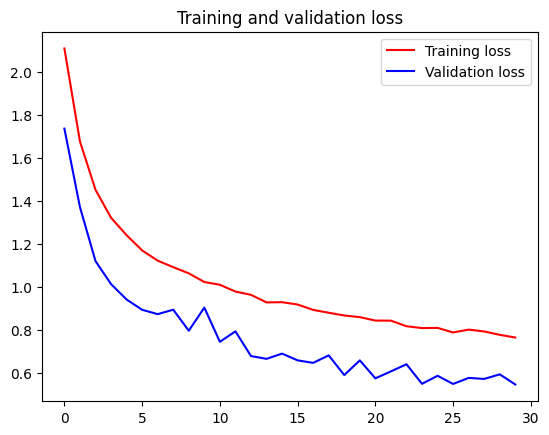

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
# 1. Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - acc: 0.7838 - loss: 0.6243
Test Accuracy: 0.8097
 Test Loss: 0.5589


In [26]:
# 2. Predictions
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step


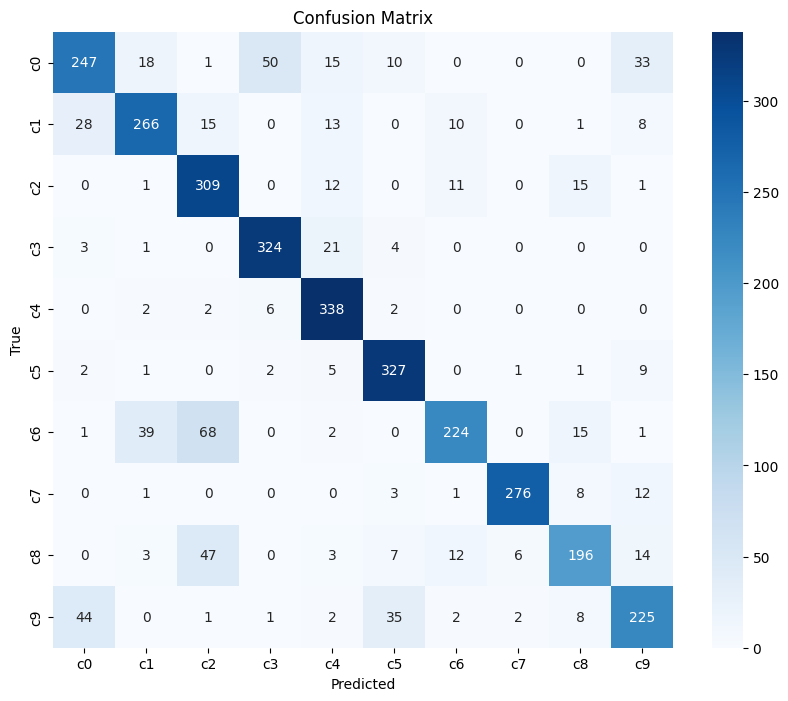

In [27]:
# 3. Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [28]:
from sklearn.metrics import classification_report
print("\n Classification Report:\n")
print(classification_report(test_generator.classes, y_pred,
                            target_names=list(test_generator.class_indices.keys())))


 Classification Report:

              precision    recall  f1-score   support

          c0       0.76      0.66      0.71       374
          c1       0.80      0.78      0.79       341
          c2       0.70      0.89      0.78       349
          c3       0.85      0.92      0.88       353
          c4       0.82      0.97      0.89       350
          c5       0.84      0.94      0.89       348
          c6       0.86      0.64      0.73       350
          c7       0.97      0.92      0.94       301
          c8       0.80      0.68      0.74       288
          c9       0.74      0.70      0.72       320

    accuracy                           0.81      3374
   macro avg       0.81      0.81      0.81      3374
weighted avg       0.81      0.81      0.81      3374



In [29]:
# 5. Per-class accuracy
cm_diag = np.diag(cm) / np.sum(cm, axis=1)
for idx, cls in enumerate(test_generator.class_indices.keys()):
    print(f"Class {cls}: {cm_diag[idx]*100:.2f}% accuracy")

Class c0: 66.04% accuracy
Class c1: 78.01% accuracy
Class c2: 88.54% accuracy
Class c3: 91.78% accuracy
Class c4: 96.57% accuracy
Class c5: 93.97% accuracy
Class c6: 64.00% accuracy
Class c7: 91.69% accuracy
Class c8: 68.06% accuracy
Class c9: 70.31% accuracy
